In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [3]:
num_test = 3
result_i3d = []
result_r21d = []
for run in range(num_test):
    tmp_result_i3d = pd.DataFrame()
    tmp_result_r21d = pd.DataFrame()
    for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
        file_name_i3d = 'test-i3d-run_0%d/result-%d.csv' % (run+1, i)
        file_name_r21d = 'test-r21d-run_0%d/result-%d.csv' % (run+1, i)
        read_i3d = pd.read_csv(file_name_i3d, index_col=0)
        read_r21d = pd.read_csv(file_name_r21d, index_col=0)
        tmp_result_i3d = pd.concat([tmp_result_i3d, read_i3d], ignore_index=True)
        tmp_result_r21d = pd.concat([tmp_result_r21d, read_r21d], ignore_index=True)
    result_i3d.append(tmp_result_i3d)
    result_r21d.append(tmp_result_r21d)

In [4]:
i3d_rgb_out = []
i3d_rgb_out = []
i3d_flow_out = []
i3d_labels = []
r21d_rgb_out = []
r21d_flow_out = []
r21d_labels = []

for run in range(num_test):
    i3d_rgb_out.append(result_i3d[run].iloc[:,0:8])
    i3d_flow_out.append(result_i3d[run].iloc[:,8:16])
    i3d_labels.append(result_i3d[run].iloc[:,16])
    r21d_rgb_out.append(result_r21d[run].iloc[:,0:8])
    r21d_flow_out.append(result_r21d[run].iloc[:,8:16])
    r21d_labels.append(result_r21d[run].iloc[:,16])

In [5]:
all_i3d_mixed = []
all_r21d_mixed = []
for run in range(num_test):
    i3d_mixed = []
    r21d_mixed = []
    flow_weight = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    for weight in range(11):
        i3d_mixed.append(np.asarray(i3d_rgb_out[run])*(1-flow_weight[weight]) + np.asarray(i3d_flow_out[run])*flow_weight[weight])
        r21d_mixed.append(np.asarray(r21d_rgb_out[run])*(1-flow_weight[weight]) + np.asarray(r21d_flow_out[run])*flow_weight[weight])
    all_i3d_mixed.append(i3d_mixed)
    all_r21d_mixed.append(r21d_mixed)

In [6]:
all_i3d_sm = []
all_r21d_sm = []
for run in tqdm(range(num_test)):
    i3d_sm = []
    r21d_sm = []
    for weight in range(11):
        tmp = []
        for i in range(all_i3d_mixed[run][weight].shape[0]):
            tmp.append(softmax(all_i3d_mixed[run][weight][i]))
        i3d_sm.append(np.asarray(tmp))
        r_tmp = []
        for i in range(all_r21d_mixed[run][weight].shape[0]):
            r_tmp.append(softmax(all_r21d_mixed[run][weight][i]))
        r21d_sm.append(np.asarray(r_tmp))
    all_i3d_sm.append(i3d_sm)
    all_r21d_sm.append(r21d_sm)
print(all_i3d_sm[0][5][0])
print(all_i3d_sm[1][5][0])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:08<00:00, 42.74s/it]


[5.87237111e-04 4.81263504e-01 6.26698813e-05 6.90585165e-07
 6.90121080e-06 5.18078252e-01 9.08233130e-08 6.54788317e-07]
[7.43233252e-04 9.68484714e-01 4.34094096e-05 3.07072207e-05
 2.28331521e-06 3.06924839e-02 2.83954273e-06 3.29674204e-07]


In [7]:
from sklearn.metrics import accuracy_score

all_i3d_class_acc = []
all_r21d_class_acc = []
for run in range(num_test):
    i3d_class_acc = []
    r21d_class_acc = []
    for i in range(8):
        acc = []
        for weight in range(11):
            acc.append(accuracy_score(i3d_labels[run][i3d_labels[run]==i], all_i3d_sm[run][weight][i3d_labels[run]==i].argmax(axis=1)))
        i3d_class_acc.append(acc)
        r_acc = []
        for weight in range(11):
            r_acc.append(accuracy_score(r21d_labels[run][r21d_labels[run]==i], all_r21d_sm[run][weight][r21d_labels[run]==i].argmax(axis=1)))
        r21d_class_acc.append(r_acc)
    all_i3d_class_acc.append(i3d_class_acc)
    all_r21d_class_acc.append(r21d_class_acc)
print(all_r21d_class_acc[0][0])
print(all_r21d_class_acc[1][0])

[0.9772113943028485, 0.9769115442278861, 0.9775112443778111, 0.9775112443778111, 0.975712143928036, 0.9517241379310345, 0.9001499250374813, 0.8377811094452774, 0.7901049475262368, 0.758920539730135, 0.720839580209895]
[0.8548725637181409, 0.8566716641679161, 0.8545727136431784, 0.8446776611694153, 0.8404797601199401, 0.8194902548725638, 0.7784107946026987, 0.7355322338830584, 0.6896551724137931, 0.6476761619190404, 0.616791604197901]


In [8]:
all_i3d_acc = []
all_r21d_acc = []
for run in range(num_test):
    i3d_acc = []
    r21d_acc = []
    for weight in range(11):
        i3d_acc.append(accuracy_score(i3d_labels[run], all_i3d_sm[run][weight].argmax(axis=1)))
    for weight in range(11):
        r21d_acc.append(accuracy_score(r21d_labels[run], all_r21d_sm[run][weight].argmax(axis=1)))
    all_i3d_acc.append(i3d_acc)
    all_r21d_acc.append(r21d_acc)
print(all_i3d_acc[0])
print(all_i3d_acc[1])

[0.903500635301777, 0.9290002135174017, 0.9461726130679651, 0.9586336286407342, 0.9664707673675405, 0.9700550594873483, 0.9709686339436664, 0.9697225323863895, 0.9673388381153064, 0.9639400611149809, 0.9601002481702259]
[0.9268755403565391, 0.9424238075403145, 0.9547973159812525, 0.9627814666895352, 0.9673353378300331, 0.9684484285469266, 0.9677238694953638, 0.9647171244456423, 0.9606917963814051, 0.9557983975694019, 0.949746404331953]


In [9]:
accuracies = []
for i in range(8):
    tmp_result = []
    for run in range(num_test):
        i3d_result_acc = pd.DataFrame({'accuracy':all_i3d_class_acc[run][i],'model':'i3d','flow_weight':flow_weight,'run':run})
        r21d_result_acc = pd.DataFrame({'accuracy':all_r21d_class_acc[run][i],'model':'r(2+1)d','flow_weight':flow_weight,'run':run})
        result_acc = pd.concat([i3d_result_acc, r21d_result_acc], ignore_index=True)
        tmp_result.append(result_acc)
    acc_result = tmp_result[0]
    for id in range(len(tmp_result)-1):
        acc_result = pd.concat([acc_result, tmp_result[id+1]], ignore_index=True)
    accuracies.append(acc_result)
accuracies[1]

,accuracy,flow_weight,model,run
0,0.894675,0.0,i3d,0
1,0.915635,0.1,i3d,0
2,0.933444,0.2,i3d,0
3,0.947403,0.3,i3d,0
4,0.956023,0.4,i3d,0
5,0.958605,0.5,i3d,0
6,0.957555,0.6,i3d,0
7,0.955017,0.7,i3d,0
8,0.951166,0.8,i3d,0
9,0.945303,0.9,i3d,0


In [10]:
all_result_acc = []
for run in range(num_test):
    all_i3d_result_acc = pd.DataFrame({'accuracy':all_i3d_acc[run],'model':'i3d','flow_weight':flow_weight,'run':run})
    all_r21d_result_acc = pd.DataFrame({'accuracy':all_r21d_acc[run],'model':'r(2+1)d','flow_weight':flow_weight,'run':run})
    all_result_acc.append(pd.concat([all_i3d_result_acc, all_r21d_result_acc], ignore_index=True))
accuracy_all = all_result_acc[0]
for id in range(len(all_result_acc)-1):
    accuracy_all = pd.concat([accuracy_all, all_result_acc[id+1]], ignore_index=True)
accuracy_all

,accuracy,flow_weight,model,run
0,0.903501,0.0,i3d,0
1,0.929000,0.1,i3d,0
2,0.946173,0.2,i3d,0
3,0.958634,0.3,i3d,0
4,0.966471,0.4,i3d,0
5,0.970055,0.5,i3d,0
6,0.970969,0.6,i3d,0
7,0.969723,0.7,i3d,0
8,0.967339,0.8,i3d,0
9,0.963940,0.9,i3d,0


In [31]:
for i in range(len(accuracies)):
    accuracies[i].accuracy *= 100

C:\Users\Guest NGN\Anaconda3\envs\ml\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


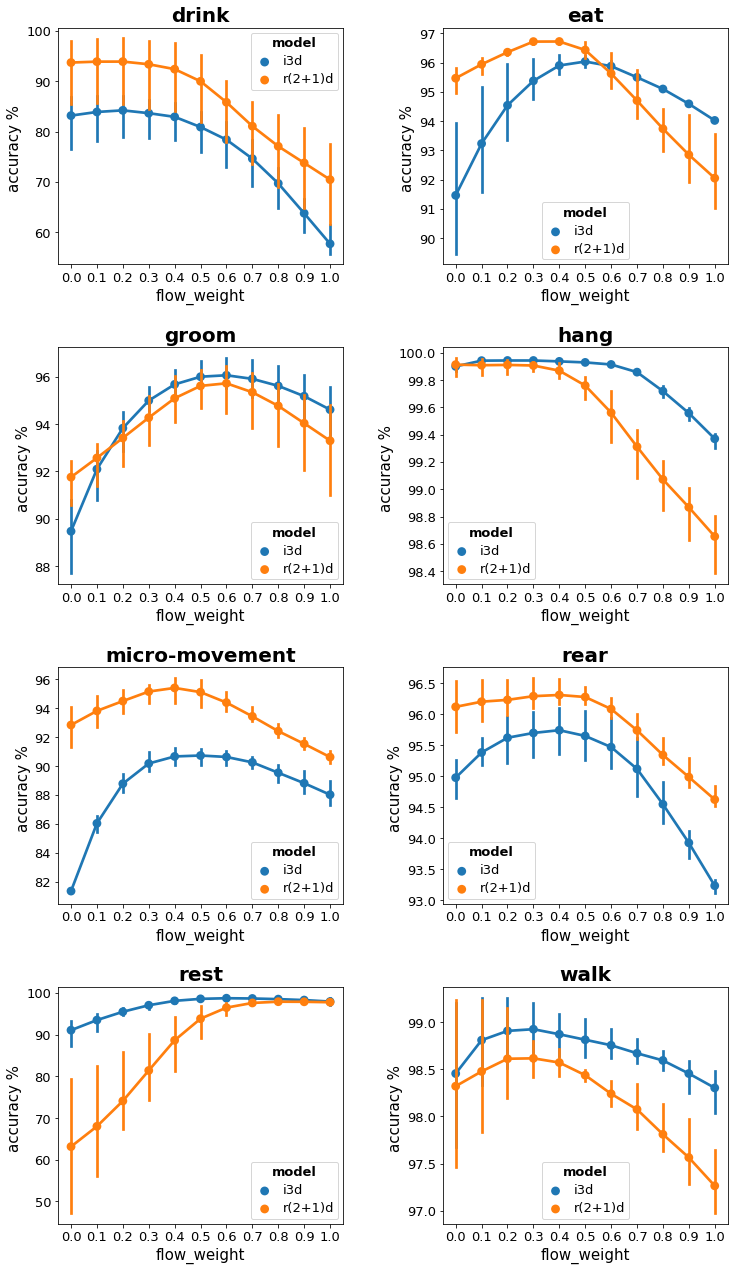

In [45]:
class_labels = ['drink', 'eat', 'groom', 'hang', 'micro-movement', 'rear', 'rest', 'walk']
f,ax=plt.subplots(4,2,figsize=(12,22))
for i in range(8):
    g = sns.pointplot('flow_weight','accuracy',hue='model',data=accuracies[i],ax=ax[int(i/2),i%2])
    ax[int(i/2),i%2].set_title(class_labels[i], fontweight="bold", size=20)
    ax[int(i/2),i%2].set_xlabel('flow_weight', size=15)
    ax[int(i/2),i%2].set_ylabel('accuracy % ', size=15)
    ax[int(i/2),i%2].tick_params(labelsize=13)
    plt.setp(ax[int(i/2),i%2].get_legend().get_texts(), fontsize='13') # for legend text
    plt.setp(ax[int(i/2),i%2].get_legend().get_title(), fontweight="bold", fontsize='13') # for legend title
    #g.set(xticks=np.arange(0, 110, 10))
#plt.close(8)
plt.subplots_adjust(hspace=0.35, wspace=0.35)
f.savefig('class_acc.pdf')
plt.show()

C:\Users\Guest NGN\Anaconda3\envs\ml\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


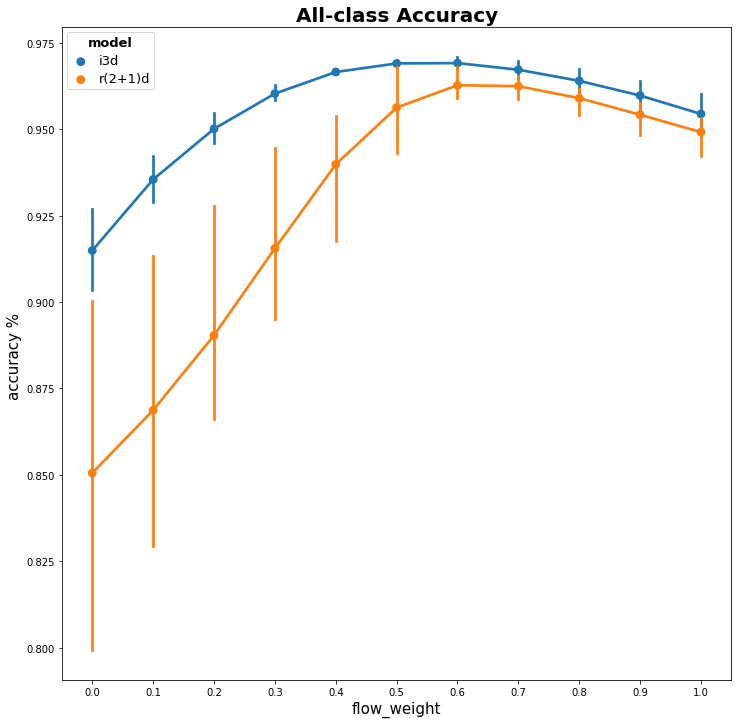

In [46]:
f,ax=plt.subplots(1,1,figsize=(12,12))
sns.pointplot('flow_weight','accuracy',hue='model',data=accuracy_all,ax=ax)
ax.set_title('All-class Accuracy', fontweight="bold", size=20)
ax.set_xlabel('flow_weight', size=15)
ax.set_ylabel('accuracy % ', size=15)
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontweight="bold", fontsize='13') # for legend title
ax.tick_params(labelsize=10)
#plt.close(8)
f.savefig('all_acc.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(r21d_labels, r21d_sm[10].argmax(axis=1))
fig,ax=plt.subplots(1,1,figsize=(7,6))
sns.heatmap(cfm, annot=True, fmt='d',ax=ax)
ax.set_title('Flow Only')
fig.savefig('r21d_flow.pdf', bbox_inches='tight')
plt.show()

In [ ]:
print(labels.shape)
sum = 0
for i in range(8):
    print(len(labels[labels==i]))
    sum+=len(labels[labels==i])
sum

In [ ]:
sm[0].argmax(axis=1)
sm[0][1]

In [ ]:
num_frames = labels.value_counts()
num_frames[sorted(num_frames.index)]

In [ ]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
majorLocator = MultipleLocator(10000)
minorLocator = MultipleLocator(2000)
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)
ax.barh(num_frames.index, num_frames.values)
ax.set_xlabel("Number of frames")
plt.yticks(sorted(num_frames.index), ('drink', 'eat', 'groom', 'hang', 'micro-movement', 'rear', 'rest', 'walk'))
plt.xticks()
#x.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)
plt.show()
fig.savefig('num_frames.pdf', bbox_inches='tight')

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()